In [1]:
# Cervical Cancer Risk Prediction - Automated Machine Learning Pipeline
# Import required libraries

# Standard libraries
import os
import time
import warnings
import joblib

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import (LogisticRegression,SGDClassifier)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, ExtraTreesClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

# Imbalanced-learn modules
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier

# Other machine learning libraries
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Data Loading and Initial Exploration
# Import the csv file
cancer_df = pd.read_csv('./data/risk_factors_cervical_cancer.csv')

# Replace '?' with NaN
cancer_df = cancer_df.replace('?', np.nan)

# Convert all columns to numeric type
cancer_df = cancer_df.apply(pd.to_numeric)

# Drop columns with more than 80% missing values
missing_threshold = 0.8
cancer_df = cancer_df.dropna(thresh=missing_threshold * len(cancer_df), axis=1)

# Impute remaining missing values with the mean
cancer_df.fillna(cancer_df.median(), inplace=True)

In [3]:
# 2. Automated Feature Selection
# Calculate the absolute correlation of features with the target variable
abs_corr_with_target = cancer_df.corr()['Biopsy'].abs().sort_values(ascending=False)

# Keep features with absolute correlation greater than a threshold
correlation_threshold = 0.05
features_to_keep = abs_corr_with_target[abs_corr_with_target >= correlation_threshold].index
cancer_df = cancer_df[features_to_keep]

# Separate target and features
target_df = cancer_df['Biopsy']
input_df = cancer_df.drop(columns=['Biopsy'])

# Convert to numpy arrays
X = np.array(input_df).astype('float32')
y = np.array(target_df).astype('float32').reshape(-1, 1)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [4]:
# 3. Handle Class Imbalance with SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train.ravel())

In [5]:
# 4. Automated Model Training and Evaluation
def evaluate_model(model, X_train, X_test, Y_train, Y_test):
    """Evaluate a model and return performance metrics"""
    # Train the model
    start_time = time.time()
    model.fit(X_train, Y_train.ravel())
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    
    # Calculate ROC AUC if the model has predict_proba
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(Y_test, y_pred_proba)
    except:
        roc_auc = None
    
    return {
        'model': model.__class__.__name__,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'y_pred': y_pred
    }

# Initialize models with class weighting
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SGD SVM': SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-3, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                                 scale_pos_weight=np.sum(Y_train == 0) / np.sum(Y_train == 1), random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42),  # silent=True to suppress output
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(class_weight='balanced', random_state=42),
    'Balanced Bagging': BalancedBaggingClassifier(random_state=42)
}

# Evaluate all baseline models on resampled data
baseline_results = []

for name, model in models.items():
    print(f"Training {name} with SMOTE...")
    result = evaluate_model(model, X_train_resampled, X_val, Y_train_resampled, Y_val)
    result['model'] = name
    baseline_results.append(result)
    print(f"{name} - Accuracy: {result['accuracy']:.4f}, F1: {result['f1_score']:.4f}")

# Select the best baseline model
best_baseline_model = max(baseline_results, key=lambda x: x['f1_score'])
print(f"\nBest Baseline Model: {best_baseline_model['model']} with F1 Score: {best_baseline_model['f1_score']:.4f}")

Training Logistic Regression with SMOTE...
Logistic Regression - Accuracy: 0.9612, F1: 0.7059
Training Random Forest with SMOTE...
Random Forest - Accuracy: 0.9535, F1: 0.6250
Training SGD SVM with SMOTE...
SGD SVM - Accuracy: 0.9690, F1: 0.7500
Training Gradient Boosting with SMOTE...
Gradient Boosting - Accuracy: 0.9535, F1: 0.6250
Training XGBoost with SMOTE...
XGBoost - Accuracy: 0.9612, F1: 0.7059
Training Neural Network with SMOTE...
Neural Network - Accuracy: 0.9380, F1: 0.4286
Training KNN with SMOTE...
KNN - Accuracy: 0.9612, F1: 0.7059
Training LightGBM with SMOTE...
[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 1

In [6]:
# 5. Automated Hyperparameter Tuning
# Define hyperparameter grids for tuning
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SGD SVM': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength
        'penalty': ['l2', 'l1', 'elasticnet'],  # Type of regularization
        'learning_rate': ['constant', 'optimal', 'adaptive'],  # Learning rate schedule
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1: Manhattan, 2: Euclidean
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100]
    },
    'CatBoost': {
        'iterations': [50, 100, 200],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Balanced Bagging': {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0]
    }
}

# Perform hyperparameter tuning for the top 3 models
tuned_models = {}
for model_name, model in models.items():
    print(f"\nTuning {model_name}...")
    grid_search = RandomizedSearchCV(
        model,
        param_grids[model_name],
        cv=5,
        n_jobs=-1,
        scoring='f1',
        n_iter=20,
        random_state=42
    )
    grid_search.fit(X_train_resampled, Y_train_resampled.ravel())
    tuned_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")


Tuning Logistic Regression...
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10}
Best F1 score: 0.9515

Tuning Random Forest...
Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best F1 score: 0.9752

Tuning SGD SVM...
Best parameters for SGD SVM: {'penalty': 'l1', 'learning_rate': 'optimal', 'alpha': 0.001}
Best F1 score: 0.9570

Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 3, 'learning_rate': 0.01}
Best F1 score: 0.9751

Tuning XGBoost...
Best parameters for XGBoost: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best F1 score: 0.9736

Tuning Neural Network...
Best parameters for Neural Network: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'relu'}
Best F1 score: 0.9762

Tun

In [7]:
# 6. Evaluate Tuned Models
tuned_results = []
for name, model in tuned_models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(model, X_train_resampled, X_val, Y_train_resampled, Y_val)
    result['model'] = name
    tuned_results.append(result)
    print(f"{name} - Accuracy: {result['accuracy']:.4f}, F1: {result['f1_score']:.4f}")

# Select the best model overall
final_results = baseline_results + tuned_results
best_model_result = max(final_results, key=lambda x: x['f1_score'])
best_model_name = best_model_result['model']
best_model = tuned_models.get(best_model_name, models[best_model_name])

print(f"\nBest Model Overall: {best_model_name} with F1 Score: {best_model_result['f1_score']:.4f}")

Evaluating Logistic Regression...
Logistic Regression - Accuracy: 0.9612, F1: 0.7059
Evaluating Random Forest...
Random Forest - Accuracy: 0.9457, F1: 0.5333
Evaluating SGD SVM...
SGD SVM - Accuracy: 0.9612, F1: 0.7059
Evaluating Gradient Boosting...
Gradient Boosting - Accuracy: 0.9612, F1: 0.7059
Evaluating XGBoost...
XGBoost - Accuracy: 0.9612, F1: 0.7059
Evaluating Neural Network...
Neural Network - Accuracy: 0.9535, F1: 0.5000
Evaluating KNN...
KNN - Accuracy: 0.9457, F1: 0.5333
Evaluating LightGBM...
[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive ga

In [8]:
# 7. Save the Best Model and Artifacts
import os
os.makedirs('model_artifacts', exist_ok=True)

# Save the best model
model_filename = f'model_artifacts/cervical_cancer_best_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nBest model saved to: {model_filename}")

# Save the scaler
scaler_filename = 'model_artifacts/cervical_cancer_scaler.joblib'
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to: {scaler_filename}")

# Save feature names
feature_names_filename = 'model_artifacts/feature_names.joblib'
joblib.dump(list(input_df.columns), feature_names_filename)
print(f"Feature names saved to: {feature_names_filename}")


Best model saved to: model_artifacts/cervical_cancer_best_model.joblib
Scaler saved to: model_artifacts/cervical_cancer_scaler.joblib
Feature names saved to: model_artifacts/feature_names.joblib


Training final model on 1249 samples...

Final Test Set Evaluation:
Model: SGD SVM
Test Accuracy: 0.9457
Test Precision: 0.5385
Test Recall: 0.8750
Test F1 Score: 0.6667


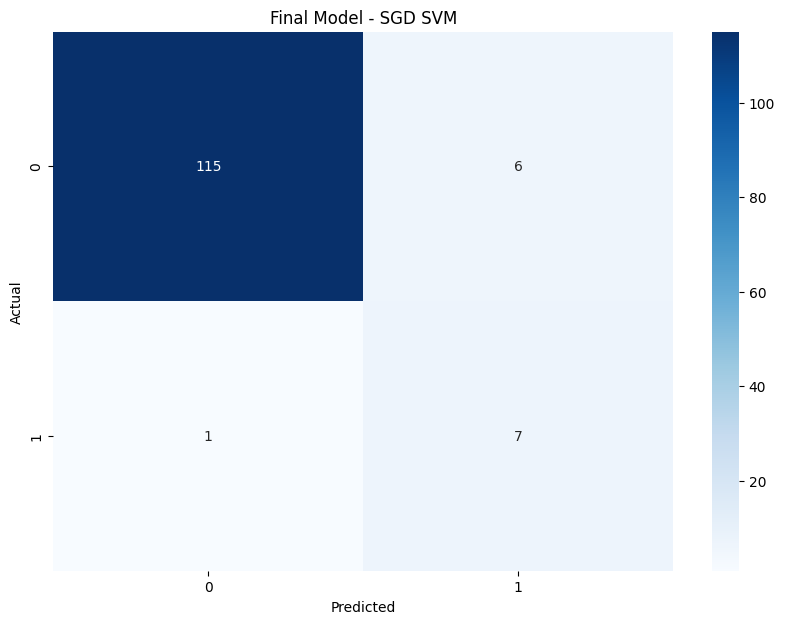


Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       121
         1.0       0.54      0.88      0.67         8

    accuracy                           0.95       129
   macro avg       0.76      0.91      0.82       129
weighted avg       0.96      0.95      0.95       129



In [9]:
# 8. Final Evaluation on Test Set
# Fit the best model on the combined training and validation data
X_train_full = np.vstack((X_train_resampled, X_val))
Y_train_full = np.vstack((Y_train_resampled.reshape(-1, 1), Y_val))

print(f"Training final model on {X_train_full.shape[0]} samples...")
best_model.fit(X_train_full, Y_train_full.ravel())

# Make predictions on test set
test_predictions = best_model.predict(X_test)

# Calculate final metrics
final_accuracy = accuracy_score(Y_test, test_predictions)
final_precision = precision_score(Y_test, test_predictions)
final_recall = recall_score(Y_test, test_predictions)
final_f1 = f1_score(Y_test, test_predictions)

print("\nFinal Test Set Evaluation:")
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Test Precision: {final_precision:.4f}")
print(f"Test Recall: {final_recall:.4f}")
print(f"Test F1 Score: {final_f1:.4f}")

# Define plot_confusion_matrix function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot final confusion matrix
plot_confusion_matrix(Y_test, test_predictions, f"Final Model - {best_model_name}")

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(Y_test, test_predictions))

In [10]:
# 9. Summary and Conclusions
print("\n=== Cervical Cancer Risk Prediction Model Summary ===")
print(f"Best model: {best_model_name}")
print(f"Test set accuracy: {final_accuracy:.4f}")
print(f"Test set F1 score: {final_f1:.4f}")
print(f"Test set precision: {final_precision:.4f}")
print(f"Test set recall: {final_recall:.4f}")

# %%
# End of notebook
print("\nNotebook completed successfully!")


=== Cervical Cancer Risk Prediction Model Summary ===
Best model: SGD SVM
Test set accuracy: 0.9457
Test set F1 score: 0.6667
Test set precision: 0.5385
Test set recall: 0.8750

Notebook completed successfully!
